# Demographic challenges in France - and in the rest of EU

## Introduction

In France, many people have protested against President Macron's plan to raise the retirement age by two years, making it 64 instead of 62. In a Danish context, a retirement age of 64 may seem low. In this project, we will examine pensions in European countries (France, Denmark, Germany, Sweden and United Kingdom) and illustrate the demographic challenges they face.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import eurostat
from matplotlib.ticker import MaxNLocator

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Importing pandas datareader
import pandas_datareader.data as web # install with `%pip install pandas-datareader`
import datetime as dt


# Age of labour market exit

We now exanime the effective age of labour market exit in France and the other European countries and calculate the EU mean:

**Importing and cleaning data**

In [2]:

start_time = dt.datetime(2020,1,1)
end_time = dt.datetime(2020,1,1)

#Fetching "Pension at a Glance" (PAG) dataset for 2020
pag = web.DataReader('PAG', 'oecd',start_time, end_time)

pag = pag.T.reset_index() #Transposing rows and columns

pag.columns.name = None #Removing name from index row


# List of variables to keep
indicators_to_keep = ['Effective labour market exit age, men', 'Effective labour market exit age, women']

# Filter rows such that we keep wanted variables
pag = pag.loc[pag['Indicator'].isin(indicators_to_keep)]


pag.head()


,Country,Indicator,2020-01-01 00:00:00
46,Australia,"Effective labour market exit age, men",64.1
47,Australia,"Effective labour market exit age, women",63.1
114,Austria,"Effective labour market exit age, men",61.6
115,Austria,"Effective labour market exit age, women",60.1
182,Belgium,"Effective labour market exit age, men",60.4


In [3]:
# Renaming last column
pag.rename(columns={pag.columns[-1]: 'Unit'}, inplace=True)

# Printing unique countries for inspection
countries = pag['Country'].unique()

# Create list of EU countries. We do this because we want to calculate the means in EU.
EU_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Republic of Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

# Filter dataframe such that we only keep EU countries.
pag_eu = pag[pag['Country'].isin(EU_countries)]

# Grouping dataframe by market retirement age for men and women and calculate the mean to get the EU mean exit age.
eu_mean_exit_age_men = pag_eu.loc[pag_eu['Indicator'] == 'Effective labour market exit age, men'].groupby('Indicator')['Unit'].mean().reset_index()
eu_mean_exit_age_women = pag_eu.loc[pag_eu['Indicator'] == 'Effective labour market exit age, women'].groupby('Indicator')['Unit'].mean().reset_index()
# Appending the calculated means
eu_mean_exit_age = pd.concat([eu_mean_exit_age_men, eu_mean_exit_age_women])

print(eu_mean_exit_age)


                                 Indicator    Unit
0    Effective labour market exit age, men  62.256
0  Effective labour market exit age, women  61.216


We see that the average age of labour market exit in the EU is 62.26 for men and 61.22 for women

**Merge**

In [4]:
# Merging our pag dataset with the created dataframe contain the EU means. The merge is a m:1
pag_merged = pd.merge(pag, eu_mean_exit_age, on='Indicator', how='left')

# Renaming columns
pag_merged.rename(columns={pag_merged.columns[2]: 'age'}, inplace=True)
pag_merged.rename(columns={pag_merged.columns[3]: 'eu_mean'}, inplace=True)
pag_merged

# Filtering out countries of interest: Denmark, France, Germany, Sweden, UK, Greece
countries_of_interest = ['Denmark','France','Germany', 'Sweden', 'United Kingdom']

pag_final = pag_merged[pag_merged['Country'].isin(countries_of_interest)]


**Creating plot of effective labour market exit for men and women in each country**

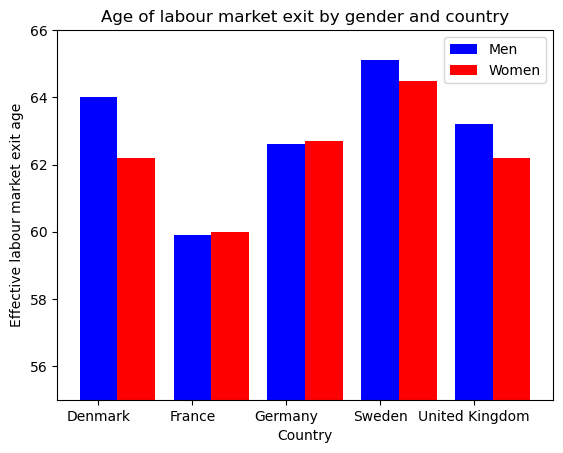

In [5]:
# Transforming data such that 'Effective labour market exit age, men' and 'Effective labour market exit age, women' have their own columns. This is done to create the bar charts later.
pag_pivot = pag_final.pivot_table(index='Country', columns='Indicator', values='age').reset_index()

# Setting bar width
bar_width = 0.4

# Generating sequence of x-values to determine x-coordinates
x_values = np.arange(len(pag_pivot['Country']))

# Creating figure and axis objects
fig, ax = plt.subplots()

ax.bar(x_values, pag_pivot['Effective labour market exit age, men'], label='Men', color='b', width=bar_width)
ax.bar(x_values + bar_width, pag_pivot['Effective labour market exit age, women'], label='Women', color='r', width=bar_width) #Adding bar_width such they don't overlap
ax.set_xticks(x_values)
ax.set_xticklabels(pag_pivot['Country'])
ax.set_xlabel('Country')
ax.set_ylabel('Effective labour market exit age')
ax.set_title('Age of labour market exit by gender and country')
ax.legend()

# Setting y-axis range
ax.set_ylim([55, 66])

plt.show()



We see that France has the lowest effective age of labour market exit while Sweden and Denmark have the highest.

**Demeaning ages**


We now want to demean the ages to see how much the retirement ages differ from the EU mean

In [6]:
# Demean for men and women
pag_final['age_demeaned'] = pag_final.age-pag_final.eu_mean


/var/folders/yv/8wvls0355h7g_33zxsdkqb580000gn/T/ipykernel_3326/4004786710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pag_final['age_demeaned'] = pag_final.age-pag_final.eu_mean


Plot of demeaned age

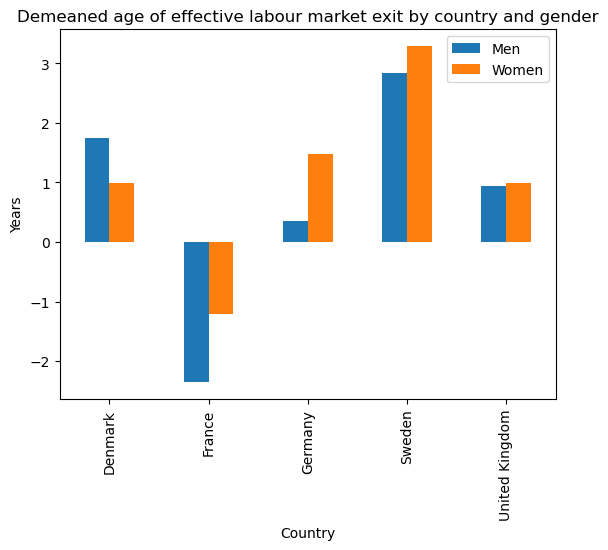

In [7]:

# We now pivot the data such that we the data grouped by country as index and the demeaned ages for men and women as columns.
pag_pivot_2 = pd.pivot_table(pag_final, values='age_demeaned', index=['Country'], columns=['Indicator'])
# Renaming columns and index in new dataframe
pag_pivot_2.columns = ['age_demeaned_men', 'age_demeaned_women']


# Plottin pivot table
ax = pag_pivot_2.plot(kind='bar')
ax.set_title('Demeaned age of effective labour market exit by country and gender')
ax.set_xlabel('Country')
ax.set_ylabel('Years')
ax.legend(labels=['Men', 'Women'])
plt.show()

In the above plot we see that the age of labour market exit is above the EU means for all countries but France.

## Old age pensions part of GDP

We will now examine the percentage of GDP that is allocated to old age pensions in the countries of interest. It is important to note that this figure does not indicate how much is actually being spent, and certain countries may have policies that reduce tax burdens for the elderly, which could obscure the overall picture.

#### Expenses on pension

**Importing and cleaning data**

In [8]:
# Fetching data set with expenses at pensions
pens = eurostat.get_data_df('SPR_EXP_PENS') 
pens

,freq,spdepb,spdepm,unit,geo\TIME_PERIOD,1990,1991,1992,1993,1994,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,A,SCPANTPEN,MEANS,EUR_HAB_KP10,AT,NaN,NaN,NaN,NaN,NaN,...,0.68,0.70,0.70,0.68,0.54,0.48,0.53,0.46,0.28,0.64
1,A,SCPANTPEN,MEANS,EUR_HAB_KP10,BA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
2,A,SCPANTPEN,MEANS,EUR_HAB_KP10,BE,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,A,SCPANTPEN,MEANS,EUR_HAB_KP10,BG,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,A,SCPANTPEN,MEANS,EUR_HAB_KP10,CH,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6019,A,TOTAL,TOTAL,PPS_HAB,SE,NaN,NaN,NaN,NaN,NaN,...,3639.17,3776.24,3809.53,3760.57,3812.18,3766.00,3811.88,3761.74,3772.34,3939.54
6020,A,TOTAL,TOTAL,PPS_HAB,SI,NaN,NaN,NaN,NaN,NaN,...,2359.60,2351.02,2404.52,2399.33,2410.84,2416.79,2458.04,2517.15,2583.90,2706.08
6021,A,TOTAL,TOTAL,PPS_HAB,SK,NaN,NaN,NaN,NaN,NaN,...,1641.45,1694.79,1767.63,1848.34,1890.60,1753.40,1745.37,1756.92,1791.12,1829.97
6022,A,TOTAL,TOTAL,PPS_HAB,TR,NaN,NaN,NaN,NaN,NaN,...,1027.41,1091.88,1135.33,1214.29,1304.43,1419.53,1427.88,1465.26,1498.09,1443.23


In [9]:
# Renaming coulmns
pens.rename(columns = {'geo\TIME_PERIOD':'country'}, inplace=True)

# Dropping years we are not interested in and the column freq 
drop = [str(num) for num in range(1990,2012)]
drop1 = [str(num) for num in range(2019,2021)]
drop2 = ['freq']
drop = drop + drop1 + drop2 
pens.drop(drop, axis=1, inplace=True)

# Keeping only the countries we are interested in and EU27
J = pens.country.str.contains('DK') 
J |= pens.country.str.contains('FR')
J |= pens.country.str.contains('UK')
J |= pens.country.str.contains('SE')
J |= pens.country.str.contains('EU27_2020')
J |= pens.country.str.contains('DE')

# Keeping only old age pensions, total amount spend and data in mio. Euros. 
I = (pens.spdepb == 'SCPOLDPEN') & (pens.spdepm == 'TOTAL') & (pens.unit == 'MIO_EUR') 
pens = pens[I & J]
pens

,spdepb,spdepm,unit,country,2012,2013,2014,2015,2016,2017,2018
3562,SCPOLDPEN,TOTAL,MIO_EUR,DE,234639.71,240255.20,250371.20,262783.85,273658.46,285153.77,296657.01
3563,SCPOLDPEN,TOTAL,MIO_EUR,DK,22756.07,25341.26,27123.18,27345.40,26834.65,28417.85,29396.09
3573,SCPOLDPEN,TOTAL,MIO_EUR,EU27_2020,1061480.82,1105729.70,1140920.83,1181321.77,1211711.36,1252051.12,1293447.61
3576,SCPOLDPEN,TOTAL,MIO_EUR,FR,250629.87,259202.54,265008.23,270106.79,275188.40,280381.84,287668.70
3594,SCPOLDPEN,TOTAL,MIO_EUR,SE,39304.35,42604.06,41251.42,42045.87,43557.86,44977.43,43213.59
3598,SCPOLDPEN,TOTAL,MIO_EUR,UK,217169.58,214557.16,232626.96,265239.06,228746.27,229243.91,234430.84


In [10]:
# Wide to long in order to merge and not get more data for the same years
years = [str(num) for num in range(2012,2019)]
pens = pens.reset_index()
pens = pd.melt(pens, id_vars='country', value_vars=years, var_name='year', value_name='Pension_expenses', ignore_index=True)
pens

,country,year,Pension_expenses
0,DE,2012,234639.71
1,DK,2012,22756.07
2,EU27_2020,2012,1061480.82
3,FR,2012,250629.87
4,SE,2012,39304.35
5,UK,2012,217169.58
6,DE,2013,240255.20
7,DK,2013,25341.26
8,EU27_2020,2013,1105729.70
9,FR,2013,259202.54


#### GDP Data

**Importing and cleaning data**

In [11]:
# Fetching data set with countries GDP
GDP = eurostat.get_data_df('NAMA_10_GDP') 
GDP

,freq,unit,na_item,geo\TIME_PERIOD,1975,1976,1977,1978,1979,1980,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,CLV05_MEUR,B1G,AT,NaN,NaN,NaN,NaN,NaN,NaN,...,251167.1,252879.7,255017.1,259996.4,266016.9,272985.2,277001.4,259083.6,269392.5,283659.7
1,A,CLV05_MEUR,B1G,BA,NaN,NaN,NaN,NaN,NaN,NaN,...,9118.0,9224.4,9358.7,9658.1,9978.2,10355.7,10650.6,10358.6,11080.5,11427.6
2,A,CLV05_MEUR,B1G,BE,NaN,NaN,NaN,NaN,NaN,NaN,...,308495.4,313684.3,320657.4,323677.5,328736.7,334655.5,342451.3,325503.1,344132.7,354684.3
3,A,CLV05_MEUR,B1G,BG,NaN,NaN,NaN,NaN,NaN,NaN,...,25127.0,25373.6,26129.3,26806.7,27691.2,28654.5,29721.9,28535.0,30816.2,31876.7
4,A,CLV05_MEUR,B1G,CH,NaN,NaN,NaN,NaN,NaN,NaN,...,381505.9,390405.6,396747.1,405030.0,410565.5,422877.6,427969.5,418277.5,435957.0,445107.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29630,A,PYP_MNAC,YA1,PT,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-27.4,156.0
29631,A,PYP_MNAC,YA1,RO,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29632,A,PYP_MNAC,YA1,SI,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29633,A,PYP_MNAC,YA1,UK,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Renaming columns 
GDP.rename(columns = {'geo\TIME_PERIOD':'country'}, inplace=True)

# Dropping years we are not interested in and the column freq 
drop = [str(num) for num in range(1975,2012)]
drop1 = [str(num) for num in range(2019,2023)]
drop2 = ['freq']
drop = drop + drop1 + drop2
GDP.drop(drop, axis=1, inplace=True)

# Keeping only the countries we are interested in and EU27
K = GDP.country.str.contains('DK') 
K |= GDP.country.str.contains('FR')
K |= GDP.country.str.contains('UK')
K |= GDP.country.str.contains('SE')
K |= GDP.country.str.contains('EU27_2020')
K |= GDP.country.str.contains('DE')

# Keeping only GDP and only in the unit current mio. Euro
N = GDP.na_item.str.contains('B1GQ')
L = (GDP.unit == 'CP_MEUR')
GDP = GDP[K & L & N]
GDP

,unit,na_item,country,2012,2013,2014,2015,2016,2017,2018
10955,CP_MEUR,B1GQ,DE,2745310.0,2811350.0,2927430.0,3026180.0,3134740.0,3267160.0,3365450.0
10956,CP_MEUR,B1GQ,DK,254578.0,258742.7,265757.0,273017.6,283109.7,294808.2,302328.7
10965,CP_MEUR,B1GQ,EU27_2020,11396449.5,11516210.9,11782085.3,12215145.8,12548705.7,13074833.0,13533330.2
10968,CP_MEUR,B1GQ,FR,2088804.0,2117189.0,2149765.0,2198432.0,2234129.0,2297242.0,2363306.0
10987,CP_MEUR,B1GQ,SE,430037.1,441850.7,438833.9,455494.7,466266.5,480025.5,470673.1
10991,CP_MEUR,B1GQ,UK,2111028.9,2096338.0,2311080.2,2644716.5,2434119.2,2359789.9,2420897.2


In [13]:
# Wide to long 
GDP = GDP.reset_index()
GDP = pd.melt(GDP, id_vars='country', value_vars=years, var_name='year', value_name='GDP', ignore_index=True)
GDP

,country,year,GDP
0,DE,2012,2745310.0
1,DK,2012,254578.0
2,EU27_2020,2012,11396449.5
3,FR,2012,2088804.0
4,SE,2012,430037.1
5,UK,2012,2111028.9
6,DE,2013,2811350.0
7,DK,2013,258742.7
8,EU27_2020,2013,11516210.9
9,FR,2013,2117189.0


**Merging Data sets**

In [14]:
# Merging in order to find the pensions expenses part of GDP 
final = pd.merge(pens, GDP, on = ['country', 'year'], how='left')
final['pensions_GDP_pct']=(final.Pension_expenses/final.GDP)*100
final

,country,year,Pension_expenses,GDP,pensions_GDP_pct
0,DE,2012,234639.71,2745310.0,8.546929
1,DK,2012,22756.07,254578.0,8.938742
2,EU27_2020,2012,1061480.82,11396449.5,9.314136
3,FR,2012,250629.87,2088804.0,11.998726
4,SE,2012,39304.35,430037.1,9.139758
5,UK,2012,217169.58,2111028.9,10.287381
6,DE,2013,240255.20,2811350.0,8.545901
7,DK,2013,25341.26,258742.7,9.794000
8,EU27_2020,2013,1105729.70,11516210.9,9.601506
9,FR,2013,259202.54,2117189.0,12.242768


**Creating plot with pensions share of GDP**

In [15]:
# In order to create the different plots we make time series for each country
DK = final[final.country.str.contains('DK')]
FR = final[final.country.str.contains('FR')]
UK = final[final.country.str.contains('UK')]
SE = final[final.country.str.contains('SE')]
EU27 = final[final.country.str.contains('EU27_2020')]
DE = final[final.country.str.contains('DE')]

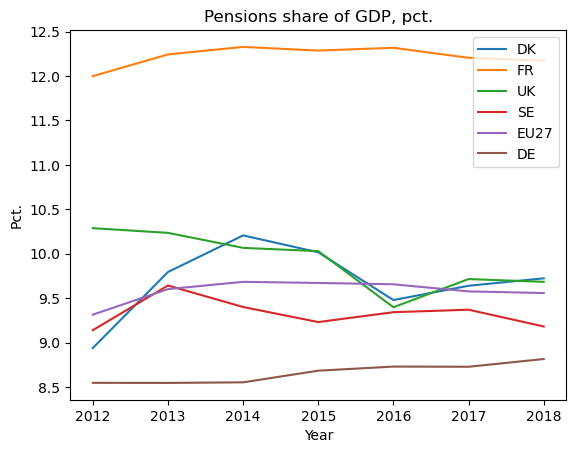

In [16]:
# Plotting
plt.plot(DK.year, DK.pensions_GDP_pct, label='DK')
plt.plot(FR.year, FR.pensions_GDP_pct, label='FR')
plt.plot(UK.year, UK.pensions_GDP_pct, label='UK')
plt.plot(SE.year, SE.pensions_GDP_pct, label='SE')
plt.plot(EU27.year, EU27.pensions_GDP_pct, label='EU27')
plt.plot(DE.year, DE.pensions_GDP_pct, label='DE')

plt.legend()
plt.xlabel("Year")
plt.ylabel("Pct.")
plt.title("Pensions share of GDP, pct.")

plt.show()

It is seen how France uses a relative high share of GDP on old age pensions

## Ratio population 65 years or over to population 15 to 64 years - also projected

To better understand the demographic challenge, it is also important to consider the proportion of elderly individuals versus young people who are able to support the expenses associated with caring for the elderly, now and in the future.

#### Historical ratioes

**Importing and cleaning data**

In [17]:
# Fetching data set with historical ratioes 
historical = eurostat.get_data_df('DEMO_PJANIND') 
historical

,freq,indic_de,geo\TIME_PERIOD,1960,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,DEPRATIO1,AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.1,NaN,NaN,NaN,NaN,NaN,37.8,NaN,NaN,NaN
1,A,DEPRATIO1,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.4,46.1,45.9,45.5,45.5,45.4,45.6,46.2,46.6,NaN
2,A,DEPRATIO1,AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,43.0,44.1,45.3,46.5,47.4,48.3,48.8,NaN
3,A,DEPRATIO1,AT,51.4,52.8,54.1,54.9,55.8,57.0,58.1,...,48.1,48.4,48.7,48.8,49.1,49.5,49.9,50.2,50.6,51.1
4,A,DEPRATIO1,AZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.0,39.3,39.6,40.2,40.8,41.1,41.3,42.0,42.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837,A,YOUNGDEP4,SM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,41.9,NaN,NaN,NaN,NaN
2838,A,YOUNGDEP4,TR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,77.4,76.4,75.4,74.1,73.1,NaN
2839,A,YOUNGDEP4,UA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,44.0,43.5,43.0,42.7,42.4,42.2
2840,A,YOUNGDEP4,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,57.6,57.3,57.1,NaN,NaN,NaN


In [18]:
# Renaming columns 
historical.rename(columns = {'geo\TIME_PERIOD':'country'}, inplace=True)

# Keeping only the countries we are interested in and EU27
K = historical.country.str.contains('DK') 
K |= historical.country.str.contains('FR')
K |= historical.country.str.contains('UK')
K |= historical.country.str.contains('SE')
K |= historical.country.str.contains('EU27_2020')
K |= historical.country.str.contains('DE')

# Keeping only GDP and only in the unit current mio. Euro
N = historical.indic_de.str.contains('OLDDEP1')
historical = historical[K & N]

# Wanting to keep the right Germany
historical = historical[~historical.country.str.contains('DE_TOT')]

# Dropping years we are not interested in and other columns.  
drop = [str(num) for num in range(1960,2012)]
drop1 = ['freq', 'indic_de']
drop = drop + drop1
historical.drop(drop, axis=1, inplace=True)

historical

,country,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
416,DE,31.4,31.5,31.6,32.0,32.0,32.4,32.8,33.2,33.7,34.2,34.7
418,DK,26.7,27.6,28.3,28.8,29.3,29.7,30.1,30.6,31.1,31.7,32.0
429,EU27_2020,27.1,27.7,28.3,29.0,29.6,30.2,30.8,31.4,32.0,32.5,33.0
432,FR,26.7,27.5,28.3,29.2,30.1,30.9,31.6,32.3,33.1,33.6,34.1
455,SE,29.2,29.9,30.6,31.1,31.5,31.6,31.7,31.9,32.1,32.4,32.6
461,UK,25.6,26.4,27.0,27.5,27.8,28.2,28.6,28.9,NaN,NaN,NaN


#### Predicted ratioes

In [19]:
# Fetching data set with historical ratioes
predicted = eurostat.get_data_df('PROJ_23NDBI')
predicted

,freq,indic_de,projection,geo\TIME_PERIOD,2022,2023,2024,2025,2026,2027,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,A,DEATH,BSL,AT,92183.0,91322.0,91336.0,91816.0,92376.0,93005.0,...,112640.0,112188.0,111758.0,111367.0,111031.0,110771.0,110566.0,110430.0,110360.0,110361.0
1,A,DEATH,BSL,BE,116710.0,115683.0,116165.0,116484.0,116796.0,117129.0,...,143851.0,143944.0,144062.0,144224.0,144450.0,144725.0,145025.0,145335.0,145652.0,145960.0
2,A,DEATH,BSL,BG,115721.0,114793.0,109714.0,108241.0,106882.0,105631.0,...,62977.0,62532.0,62242.0,62091.0,62058.0,62138.0,62284.0,62498.0,62752.0,62987.0
3,A,DEATH,BSL,CH,72524.0,73958.0,74904.0,75912.0,76928.0,77960.0,...,114386.0,113872.0,113392.0,112982.0,112656.0,112425.0,112278.0,112227.0,112273.0,112416.0
4,A,DEATH,BSL,CY,7183.0,6885.0,6932.0,7043.0,7155.0,7268.0,...,11312.0,11215.0,11116.0,11024.0,10942.0,10872.0,10814.0,10770.0,10742.0,10731.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,A,YOUNGDEP3,BSL,PT,30.6,30.5,30.4,30.2,30.1,30.0,...,34.6,34.7,34.7,34.7,34.8,34.8,34.9,34.9,35.0,35.1
636,A,YOUNGDEP3,BSL,RO,36.8,37.3,37.5,37.4,37.2,37.0,...,36.8,36.7,36.7,36.6,36.5,36.5,36.4,36.4,36.3,36.3
637,A,YOUNGDEP3,BSL,SE,41.2,41.2,41.3,41.3,41.3,41.1,...,38.7,38.6,38.6,38.5,38.4,38.4,38.3,38.2,38.1,38.0
638,A,YOUNGDEP3,BSL,SI,33.1,33.5,33.8,33.9,34.0,34.0,...,36.0,35.9,35.8,35.7,35.6,35.5,35.4,35.3,35.2,35.1


In [20]:
# Renaming columns 
predicted.rename(columns = {'geo\TIME_PERIOD':'country'}, inplace=True)

# Keeping only the countries we are interested in and EU27
K = predicted.country.str.contains('DK') 
K |= predicted.country.str.contains('FR')
K |= predicted.country.str.contains('UK')
K |= predicted.country.str.contains('SE')
K |= predicted.country.str.contains('EU27_2020')
K |= predicted.country.str.contains('DE')

# Keeping only GDP and only in the unit current mio. Euro
N = predicted.indic_de.str.contains('OLDDEP1')
predicted = predicted[K & N]

# Dropping years we are not interested in and other columns.  
drop = [str(num) for num in range(2040,2101)]
drop1 = ['freq', 'indic_de', 'projection', '2022']
drop = drop + drop1 
predicted.drop(drop, axis=1, inplace=True)

predicted

/var/folders/yv/8wvls0355h7g_33zxsdkqb580000gn/T/ipykernel_3326/3005472816.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted.drop(drop, axis=1, inplace=True)


,country,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039
294,DE,34.7,35.0,35.7,36.4,37.3,38.2,39.3,40.3,41.3,42.3,43.2,44.0,44.6,45.1,45.4,45.5,45.4
295,DK,32.3,32.6,33.0,33.5,34.1,34.6,35.4,36.2,37.0,37.9,38.6,39.0,39.4,39.8,40.2,40.8,41.1
300,EU27_2020,33.3,33.8,34.4,35.1,35.8,36.5,37.2,38.0,38.8,39.6,40.4,41.2,42.0,42.7,43.4,44.1,44.7
302,FR,34.5,35.1,35.7,36.3,37.0,37.6,38.3,39.0,39.7,40.4,41.0,41.6,42.2,42.9,43.6,44.3,44.9
317,SE,32.7,32.9,33.0,33.2,33.3,33.5,33.8,34.2,34.6,35.0,35.4,35.6,35.8,36.0,36.2,36.5,36.7


**Merging Data sets**

In [21]:
final = pd.merge(historical, predicted, on = ['country'], how='left')
final

,country,2012,2013,2014,2015,2016,2017,2018,2019,2020,...,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039
0,DE,31.4,31.5,31.6,32.0,32.0,32.4,32.8,33.2,33.7,...,40.3,41.3,42.3,43.2,44.0,44.6,45.1,45.4,45.5,45.4
1,DK,26.7,27.6,28.3,28.8,29.3,29.7,30.1,30.6,31.1,...,36.2,37.0,37.9,38.6,39.0,39.4,39.8,40.2,40.8,41.1
2,EU27_2020,27.1,27.7,28.3,29.0,29.6,30.2,30.8,31.4,32.0,...,38.0,38.8,39.6,40.4,41.2,42.0,42.7,43.4,44.1,44.7
3,FR,26.7,27.5,28.3,29.2,30.1,30.9,31.6,32.3,33.1,...,39.0,39.7,40.4,41.0,41.6,42.2,42.9,43.6,44.3,44.9
4,SE,29.2,29.9,30.6,31.1,31.5,31.6,31.7,31.9,32.1,...,34.2,34.6,35.0,35.4,35.6,35.8,36.0,36.2,36.5,36.7
5,UK,25.6,26.4,27.0,27.5,27.8,28.2,28.6,28.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Creating plot with ratios**

In [22]:
# wide to long 
years = [str(num) for num in range(2012,2040)]
final = final.reset_index()
final = pd.melt(final, id_vars='country', value_vars=years, var_name='year', value_name='old_age_ratio', ignore_index=True)
final

,country,year,old_age_ratio
0,DE,2012,31.4
1,DK,2012,26.7
2,EU27_2020,2012,27.1
3,FR,2012,26.7
4,SE,2012,29.2
...,...,...,...
163,DK,2039,41.1
164,EU27_2020,2039,44.7
165,FR,2039,44.9
166,SE,2039,36.7


In [23]:
# In order to create the different plots we make time series for each country
DK = final[final.country.str.contains('DK')]
FR = final[final.country.str.contains('FR')]
UK = final[final.country.str.contains('UK')]
SE = final[final.country.str.contains('SE')]
EU27 = final[final.country.str.contains('EU27_2020')]
DE = final[final.country.str.contains('DE')]

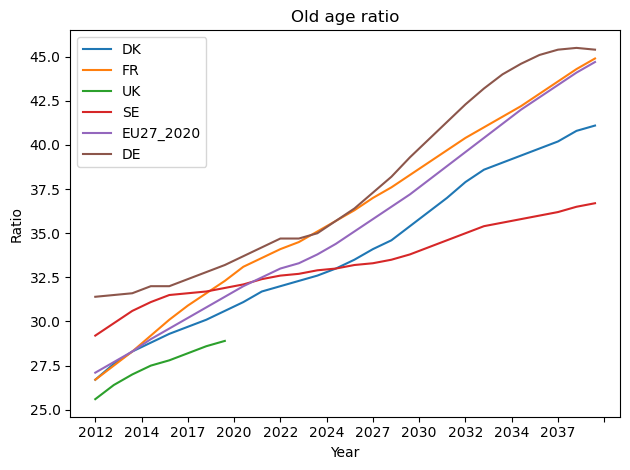

In [24]:
# Plotting
plt.plot(DK.year, DK.old_age_ratio, label='DK')
plt.plot(FR.year, FR.old_age_ratio, label='FR')
plt.plot(UK.year, UK.old_age_ratio, label='UK')
plt.plot(SE.year, SE.old_age_ratio, label='SE')
plt.plot(EU27.year, EU27.old_age_ratio, label='EU27_2020')
plt.plot(DE.year, DE.old_age_ratio, label='DE')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(14))

plt.legend()
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.title("Old age ratio")
plt.tight_layout()

plt.show()

It is seen how the ratio of population 65 years or over to population 15 to 64 years has risen in the period and continues to rise. This means that the demographic challenge is only getting bigger for the countries and for EU as a whole. UK is only shown part of the period due to Brexit and therefore no data.

## Conclusion

In this project, we have demonstrated that France has a lower effective retirement age than the EU average, as well as some individual countries. This, along with a larger-than-average share of GDP spent on pensions, may suggest the need for an increase in the retirement age. However, this is ultimately a political decision and there are other ways to finance the expenses. We have also observed how the demographic challenge has become more prominent in the EU and the selected countries, and this trend is expected to continue. France is no exception to this trend.